In [1]:
import torch
torch.cuda.is_available()

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
from basics import *

In [69]:
class ECGDataset(FilteredDataset):
    def __init__(self, data, signal_length, low_cut = 5, high_cut = 20):
        super().__init__(data, low_cut, high_cut)
        self.signal_length = signal_length
        used_data = self.filtered_data
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.values = (used_data - used_data.mean())/used_data.std()


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        label = self._get_label(idx)
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.values[idx][:, cut_point:cut_point+self.signal_length]
        
        return signals, label, self.data[idx][-1]

In [70]:
dataset = ECGDataset(data, 1000)

In [71]:
dataset.values.shape

(659, 12, 5000)

In [72]:
dataset[0][0].shape

(12, 1000)

In [73]:
ecg_loader = DataLoader(dataset, batch_size= 2)

In [74]:
for i in ecg_loader:
    print(i[0].shape)
    print(i[1].argmax(dim=1))
    break

torch.Size([2, 12, 1000])
tensor([3, 3])


In [75]:
from torch.utils.data.sampler import SubsetRandomSampler

In [76]:
valid_size = 0.1

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(7)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], 3000)
valid_dataset = ECGDataset(data.iloc[valid_idx],  3000)

In [77]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [78]:
import torch.nn as nn

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [80]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
    def init_hidden(self, batch_size):
        return torch.zeros((self.n_layers, batch_size, self.hid_dim), dtype = torch.float)
    
    def init_cell(self, batch_size):
        return torch.zeros((self.n_layers, batch_size, self.hid_dim), dtype = torch.float)
        
    def forward(self, src, h0, c0):
        
        #src = [seq len, batch size, input dim]
        #print(src.shape)
        
        outputs, (hidden, cell) = self.rnn(src, (h0, c0))
        
        
        #print(outputs.shape)
        
        #outputs = [seq_len, batch,  hidden_size]
        #hidden = [num_layers, batch, hidden_size]
        #cell = [num_layers, batch, hidden_size]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [81]:
encoder = Encoder(12, 16, 2, 0.01)

In [105]:
ecg, labels, labels_idx = dataset[0]
ecg = torch.tensor([ecg]).float()
ecg = F.avg_pool1d(ecg, 10)
ecg = ecg.transpose(1,2).transpose(0,1)

In [106]:
ecg.shape

torch.Size([100, 1, 12])

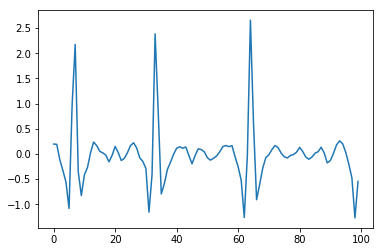

In [107]:
plt.plot(ecg.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())

In [108]:
h0 = encoder.init_hidden(1)
c0 = encoder.init_cell(1)

In [109]:
hidden, cell = encoder(ecg, h0, c0)

In [110]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dense_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, output_size]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #print(input.shape)
        
        #input = [1, batch size, output_size]
                
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.dense_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [111]:
decoder = Decoder(12, 12, 16, 2, 0.01)

In [112]:
pred, hidden2, cell2 = decoder(ecg[0], hidden, cell)

In [113]:
pred

tensor([[-0.2091,  0.1982,  0.1961, -0.0838,  0.1380, -0.0810,  0.0367,  0.0384,
          0.1312,  0.1291,  0.1530, -0.0684]], grad_fn=<AddmmBackward>)

In [114]:
import random

In [115]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,  device):
        super().__init__()
        
        self.SOS = 2
        
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        self.sigmoid = nn.Sigmoid()
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, tf_ration = 0.3):
        
        #src = [src seq len, batch size, input dim]
        #trg = [trg seq len, batch size, output dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        
        #encoder init states
        h0 = encoder.init_hidden(batch_size).to(self.device)
        c0 = encoder.init_cell(batch_size).to(self.device)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, self.decoder.output_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src, h0, c0)
        
        #first input to the decoder is the <sos> tokens
        input = torch.zeros(batch_size, self.decoder.input_dim, device = self.device, dtype = torch.float32)
        
        for t in range(0, max_len):
        
            use_tf = random.random() < tf_ration
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            input = trg[t] if use_tf else output.detach()
            
        
        return outputs

In [116]:
seq2seq = Seq2Seq(encoder, decoder, "cpu")

In [117]:
pred = seq2seq(ecg, ecg)

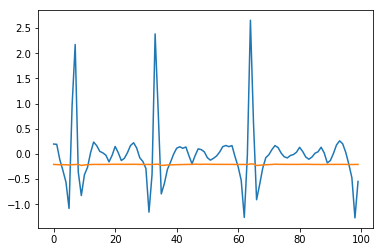

In [118]:
plt.plot(ecg.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
plt.plot(pred.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())

In [119]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [125]:
encoder = Encoder(12, 128, 4, 0.01)
decoder = Decoder(12, 12, 128, 4 , 0.01)
model = Seq2Seq(encoder, decoder, device)

In [126]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [130]:
def train(model, dataset, n_epoch, optimizer, criterion, print_every = 100, plot_every = 300, tfr = 0.3):
    model.train()
    total_step = len(train_loader)
    for epoch in range(n_epoch):
        epoch_loss = 0
        

        for i, (ecg, labels, label_idx) in enumerate(train_loader):
            
            src = ecg.to(device).float()
            trg = ecg.to(device).float()
            
            
            src = F.avg_pool1d(src, 10)
            trg = F.avg_pool1d(trg, 10)
            
            
            src = src.transpose(1,2).transpose(0,1)
            trg = trg.transpose(1,2).transpose(0,1)
            

            optimizer.zero_grad()

            output = model(src, trg, tfr)

            loss = criterion(output, trg )
            if (torch.isnan(loss).item()  == 1):
                print("NAN loss")
                print(src)
                print(trg)
                print(pred)
                return

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i % print_every == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epoch, i+1, total_step, loss.item()))
                
            if (i % plot_every == 0):
                plt.plot(src.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
                plt.plot(output.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
                plt.show()

In [131]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Epoch [1/40], Step [1/10], Loss: 0.7949


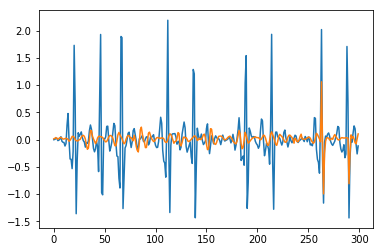

Epoch [1/40], Step [3/10], Loss: 0.8075
Epoch [1/40], Step [5/10], Loss: 0.8067
Epoch [1/40], Step [7/10], Loss: 0.8497
Epoch [1/40], Step [9/10], Loss: 0.7874


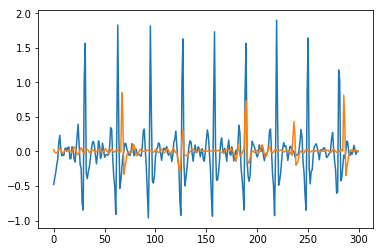

Epoch [2/40], Step [1/10], Loss: 0.7636


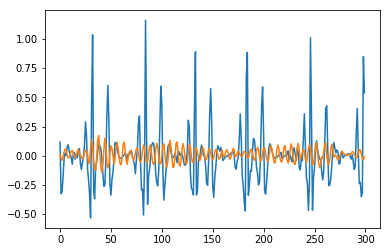

Epoch [2/40], Step [3/10], Loss: 0.6697
Epoch [2/40], Step [5/10], Loss: 0.7426
Epoch [2/40], Step [7/10], Loss: 0.8134
Epoch [2/40], Step [9/10], Loss: 0.9101


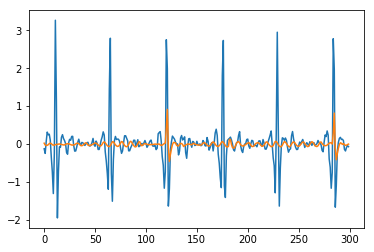

Epoch [3/40], Step [1/10], Loss: 0.6854


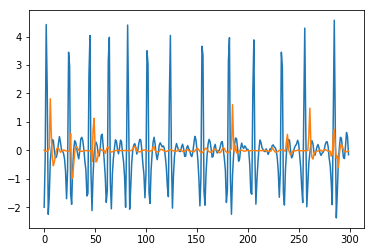

Epoch [3/40], Step [3/10], Loss: 0.8209
Epoch [3/40], Step [5/10], Loss: 0.6780
Epoch [3/40], Step [7/10], Loss: 0.7593
Epoch [3/40], Step [9/10], Loss: 0.7043


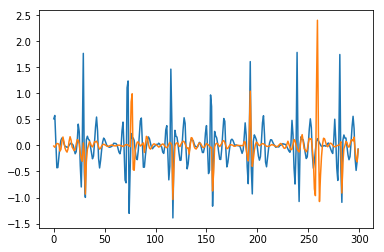

Epoch [4/40], Step [1/10], Loss: 0.6174


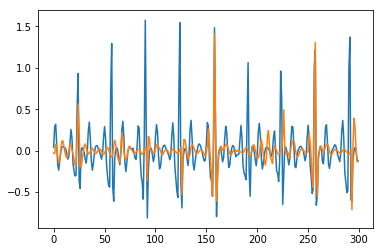

Epoch [4/40], Step [3/10], Loss: 0.7992
Epoch [4/40], Step [5/10], Loss: 0.7434
Epoch [4/40], Step [7/10], Loss: 0.7781
Epoch [4/40], Step [9/10], Loss: 0.7721


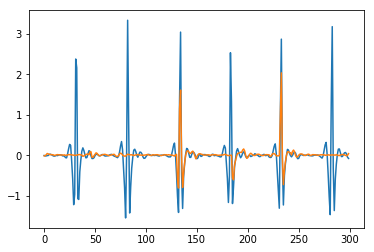

Epoch [5/40], Step [1/10], Loss: 0.7482


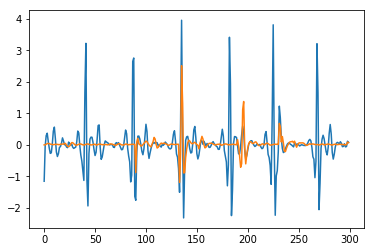

Epoch [5/40], Step [3/10], Loss: 0.8874
Epoch [5/40], Step [5/10], Loss: 0.6861
Epoch [5/40], Step [7/10], Loss: 0.7177
Epoch [5/40], Step [9/10], Loss: 0.7417


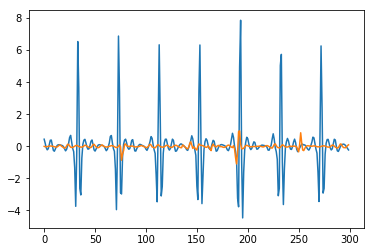

Epoch [6/40], Step [1/10], Loss: 0.7275


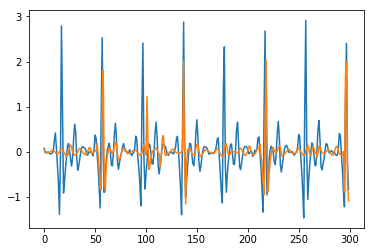

Epoch [6/40], Step [3/10], Loss: 0.8069
Epoch [6/40], Step [5/10], Loss: 0.7197
Epoch [6/40], Step [7/10], Loss: 0.8454
Epoch [6/40], Step [9/10], Loss: 0.6853


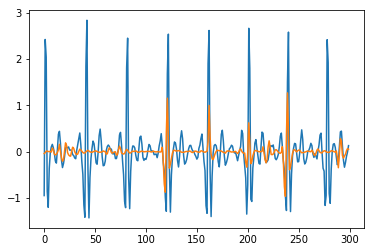

Epoch [7/40], Step [1/10], Loss: 0.7321


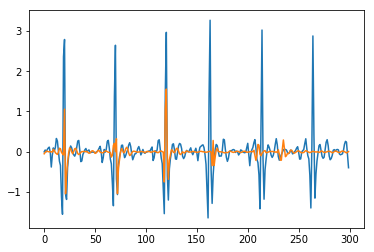

Epoch [7/40], Step [3/10], Loss: 0.7485
Epoch [7/40], Step [5/10], Loss: 0.6588
Epoch [7/40], Step [7/10], Loss: 0.7036
Epoch [7/40], Step [9/10], Loss: 0.8244


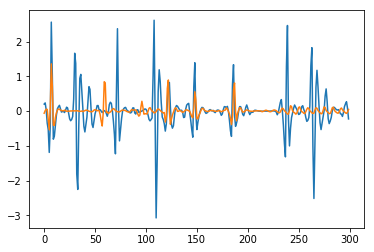

Epoch [8/40], Step [1/10], Loss: 0.6823


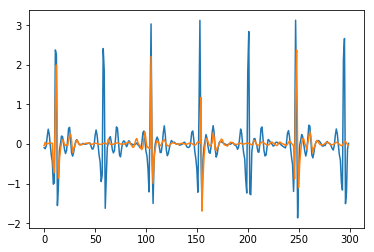

Epoch [8/40], Step [3/10], Loss: 0.8462
Epoch [8/40], Step [5/10], Loss: 0.7709
Epoch [8/40], Step [7/10], Loss: 0.7780
Epoch [8/40], Step [9/10], Loss: 0.6763


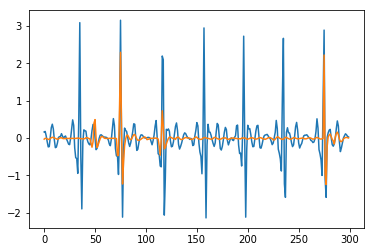

Epoch [9/40], Step [1/10], Loss: 0.6998


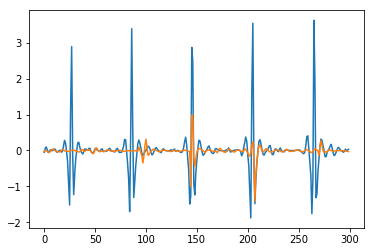

Epoch [9/40], Step [3/10], Loss: 0.7576
Epoch [9/40], Step [5/10], Loss: 0.8411
Epoch [9/40], Step [7/10], Loss: 0.8712
Epoch [9/40], Step [9/10], Loss: 0.7708


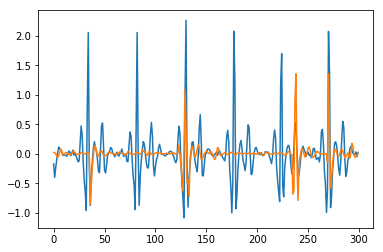

Epoch [10/40], Step [1/10], Loss: 0.7048


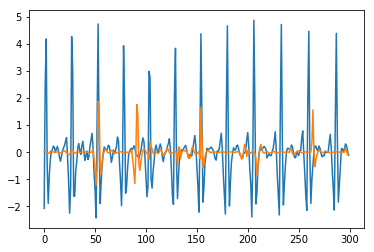

Epoch [10/40], Step [3/10], Loss: 0.8471
Epoch [10/40], Step [5/10], Loss: 0.7451
Epoch [10/40], Step [7/10], Loss: 0.7087
Epoch [10/40], Step [9/10], Loss: 0.7341


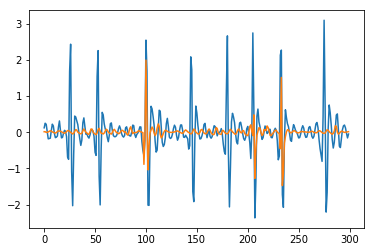

Epoch [11/40], Step [1/10], Loss: 0.7944


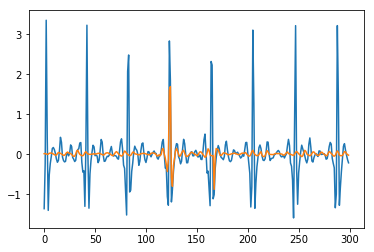

Epoch [11/40], Step [3/10], Loss: 0.6754
Epoch [11/40], Step [5/10], Loss: 0.7632
Epoch [11/40], Step [7/10], Loss: 0.8546
Epoch [11/40], Step [9/10], Loss: 0.6357


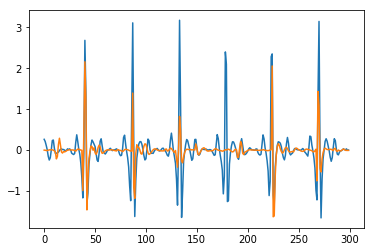

Epoch [12/40], Step [1/10], Loss: 0.8257


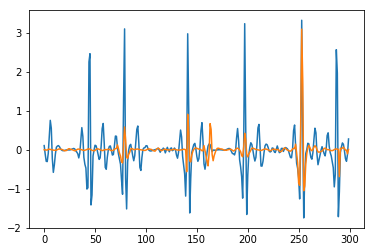

Epoch [12/40], Step [3/10], Loss: 0.6731
Epoch [12/40], Step [5/10], Loss: 0.7178
Epoch [12/40], Step [7/10], Loss: 0.7143
Epoch [12/40], Step [9/10], Loss: 0.7779


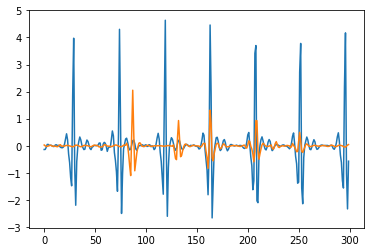

Epoch [13/40], Step [1/10], Loss: 0.7028


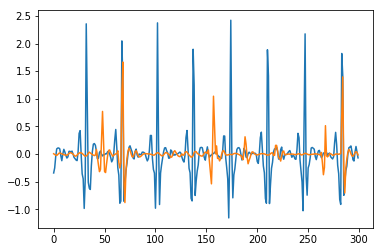

Epoch [13/40], Step [3/10], Loss: 0.7143
Epoch [13/40], Step [5/10], Loss: 0.8639
Epoch [13/40], Step [7/10], Loss: 0.6237
Epoch [13/40], Step [9/10], Loss: 0.9016


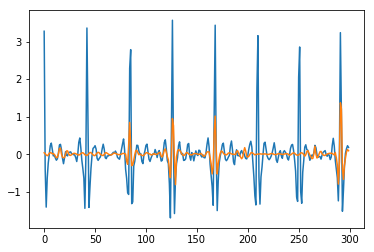

Epoch [14/40], Step [1/10], Loss: 0.6343


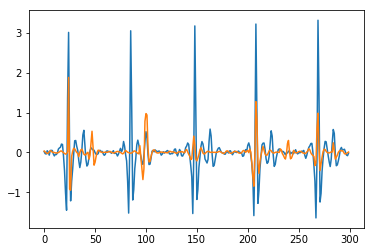

Epoch [14/40], Step [3/10], Loss: 0.7460
Epoch [14/40], Step [5/10], Loss: 0.7486
Epoch [14/40], Step [7/10], Loss: 0.7129
Epoch [14/40], Step [9/10], Loss: 0.8085


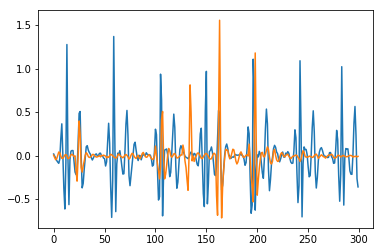

Epoch [15/40], Step [1/10], Loss: 0.9027


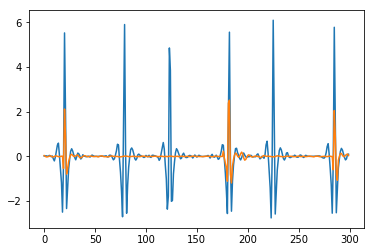

Epoch [15/40], Step [3/10], Loss: 0.7964
Epoch [15/40], Step [5/10], Loss: 0.7323
Epoch [15/40], Step [7/10], Loss: 0.7654
Epoch [15/40], Step [9/10], Loss: 0.6411


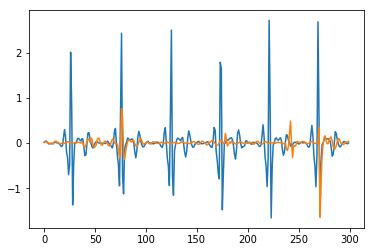

Epoch [16/40], Step [1/10], Loss: 0.7690


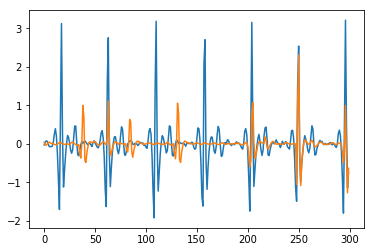

Epoch [16/40], Step [3/10], Loss: 0.7032
Epoch [16/40], Step [5/10], Loss: 0.6523
Epoch [16/40], Step [7/10], Loss: 0.6862
Epoch [16/40], Step [9/10], Loss: 0.6924


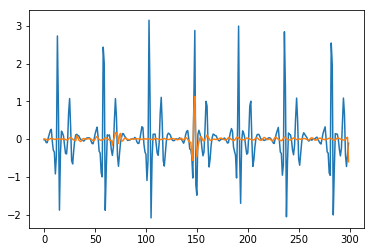

Epoch [17/40], Step [1/10], Loss: 0.8002


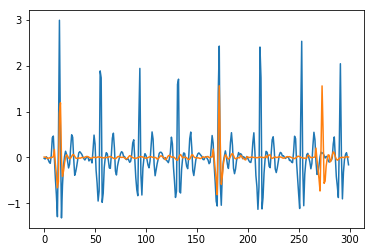

Epoch [17/40], Step [3/10], Loss: 0.6827
Epoch [17/40], Step [5/10], Loss: 0.8487
Epoch [17/40], Step [7/10], Loss: 0.7424
Epoch [17/40], Step [9/10], Loss: 0.7339


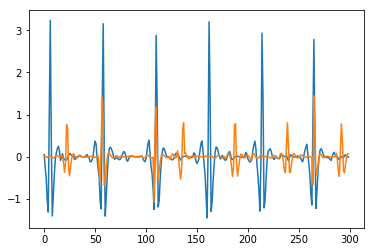

Epoch [18/40], Step [1/10], Loss: 0.7767


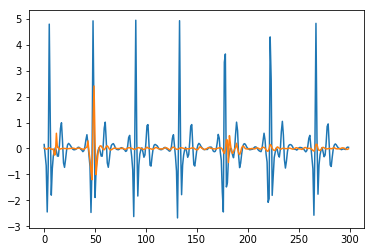

Epoch [18/40], Step [3/10], Loss: 0.6968
Epoch [18/40], Step [5/10], Loss: 0.6886
Epoch [18/40], Step [7/10], Loss: 0.8439
Epoch [18/40], Step [9/10], Loss: 0.7578


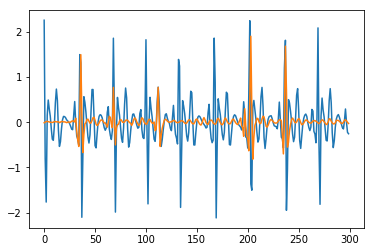

Epoch [19/40], Step [1/10], Loss: 0.8049


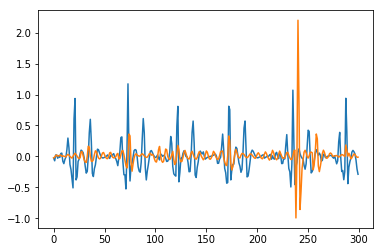

Epoch [19/40], Step [3/10], Loss: 0.8211
Epoch [19/40], Step [5/10], Loss: 0.6948
Epoch [19/40], Step [7/10], Loss: 0.7005
Epoch [19/40], Step [9/10], Loss: 0.8070


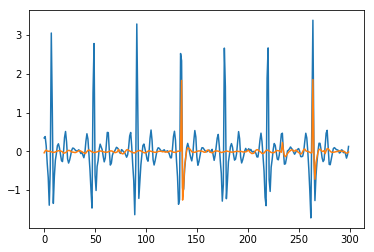

Epoch [20/40], Step [1/10], Loss: 0.7678


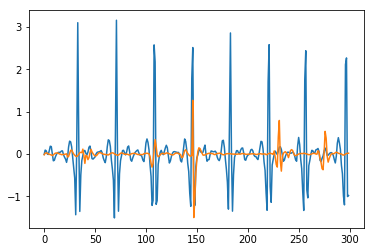

Epoch [20/40], Step [3/10], Loss: 0.8218
Epoch [20/40], Step [5/10], Loss: 0.7110
Epoch [20/40], Step [7/10], Loss: 0.6825
Epoch [20/40], Step [9/10], Loss: 0.7547


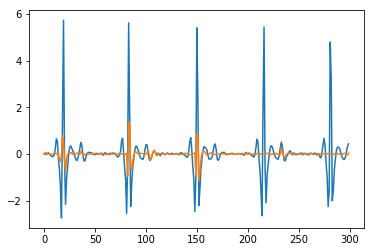

Epoch [21/40], Step [1/10], Loss: 0.8482


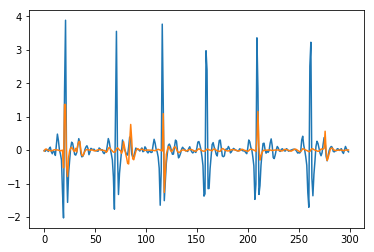

Epoch [21/40], Step [3/10], Loss: 0.9671
Epoch [21/40], Step [5/10], Loss: 0.7386
Epoch [21/40], Step [7/10], Loss: 0.6953
Epoch [21/40], Step [9/10], Loss: 0.6389


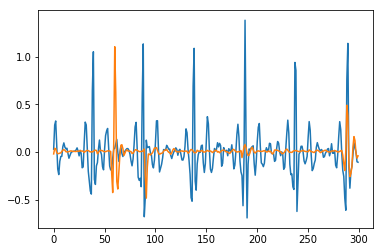

Epoch [22/40], Step [1/10], Loss: 0.8264


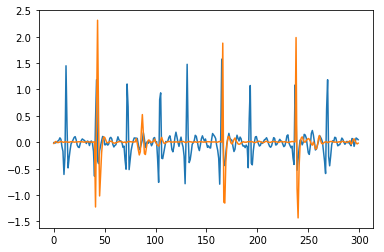

Epoch [22/40], Step [3/10], Loss: 0.8460
Epoch [22/40], Step [5/10], Loss: 0.7634
Epoch [22/40], Step [7/10], Loss: 0.6930
Epoch [22/40], Step [9/10], Loss: 0.6845


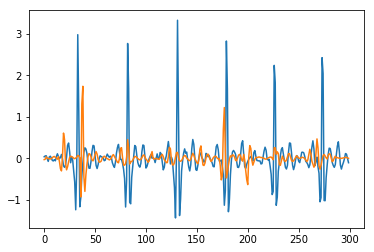

Epoch [23/40], Step [1/10], Loss: 0.6948


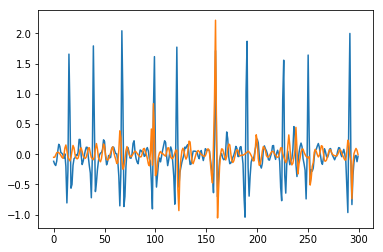

Epoch [23/40], Step [3/10], Loss: 0.7774
Epoch [23/40], Step [5/10], Loss: 0.7003
Epoch [23/40], Step [7/10], Loss: 0.7615
Epoch [23/40], Step [9/10], Loss: 0.6645


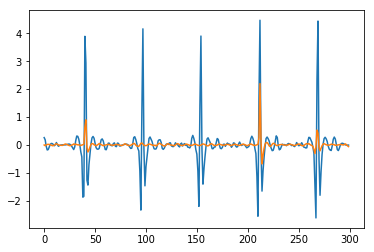

Epoch [24/40], Step [1/10], Loss: 0.7223


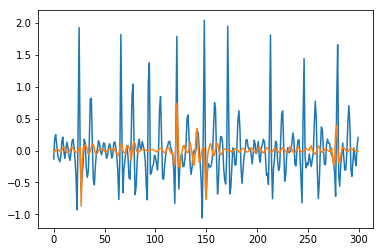

Epoch [24/40], Step [3/10], Loss: 0.7287
Epoch [24/40], Step [5/10], Loss: 0.7617
Epoch [24/40], Step [7/10], Loss: 0.7938
Epoch [24/40], Step [9/10], Loss: 0.7605


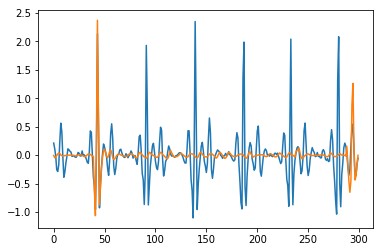

Epoch [25/40], Step [1/10], Loss: 0.8152


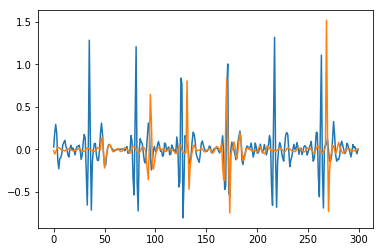

Epoch [25/40], Step [3/10], Loss: 0.6457
Epoch [25/40], Step [5/10], Loss: 0.7322
Epoch [25/40], Step [7/10], Loss: 0.7390
Epoch [25/40], Step [9/10], Loss: 0.7304


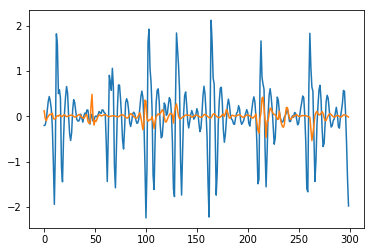

Epoch [26/40], Step [1/10], Loss: 0.6995


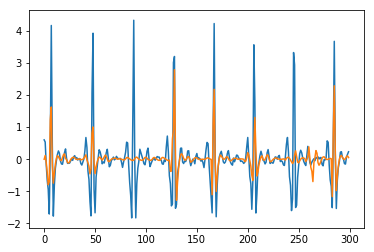

Epoch [26/40], Step [3/10], Loss: 0.7232
Epoch [26/40], Step [5/10], Loss: 0.7719
Epoch [26/40], Step [7/10], Loss: 0.7417
Epoch [26/40], Step [9/10], Loss: 0.7233


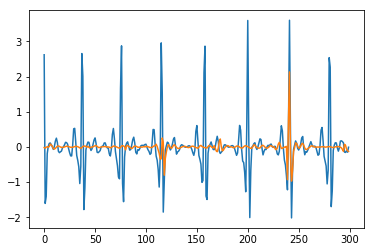

Epoch [27/40], Step [1/10], Loss: 0.7863


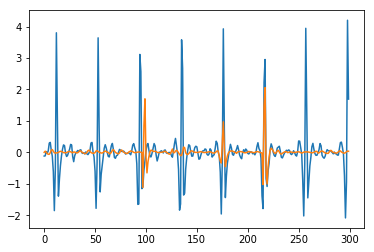

Epoch [27/40], Step [3/10], Loss: 0.6336
Epoch [27/40], Step [5/10], Loss: 0.7055
Epoch [27/40], Step [7/10], Loss: 0.7768
Epoch [27/40], Step [9/10], Loss: 0.7976


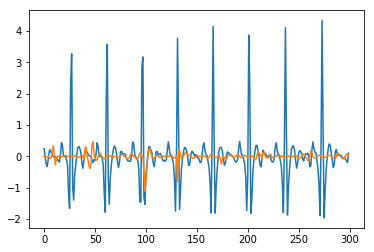

Epoch [28/40], Step [1/10], Loss: 0.7308


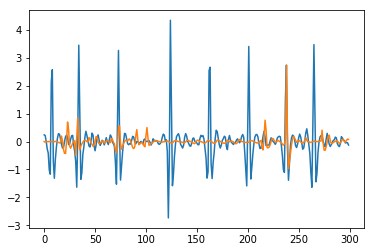

Epoch [28/40], Step [3/10], Loss: 0.7063
Epoch [28/40], Step [5/10], Loss: 0.7156
Epoch [28/40], Step [7/10], Loss: 0.7275
Epoch [28/40], Step [9/10], Loss: 0.6783


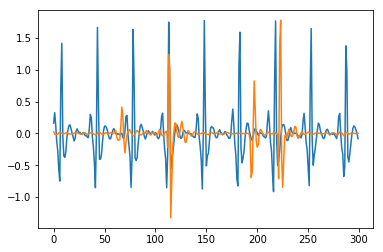

Epoch [29/40], Step [1/10], Loss: 0.7112


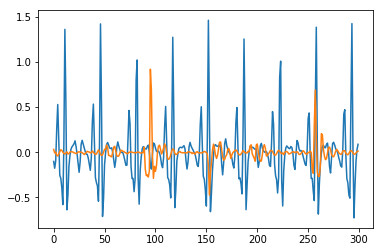

Epoch [29/40], Step [3/10], Loss: 0.7082
Epoch [29/40], Step [5/10], Loss: 0.7665
Epoch [29/40], Step [7/10], Loss: 0.8267
Epoch [29/40], Step [9/10], Loss: 0.6823


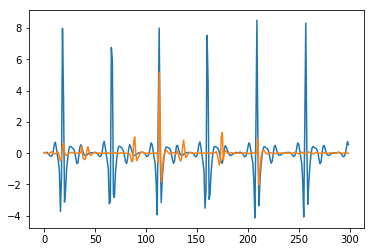

Epoch [30/40], Step [1/10], Loss: 0.7447


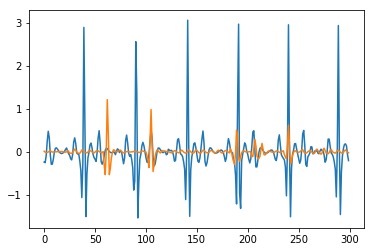

Epoch [30/40], Step [3/10], Loss: 0.8023
Epoch [30/40], Step [5/10], Loss: 0.7242
Epoch [30/40], Step [7/10], Loss: 0.6776
Epoch [30/40], Step [9/10], Loss: 0.7716


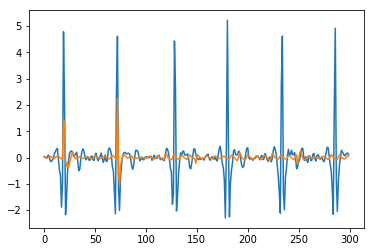

Epoch [31/40], Step [1/10], Loss: 0.7422


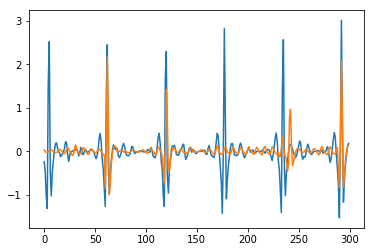

Epoch [31/40], Step [3/10], Loss: 0.6500
Epoch [31/40], Step [5/10], Loss: 0.7975
Epoch [31/40], Step [7/10], Loss: 0.8294
Epoch [31/40], Step [9/10], Loss: 0.7269


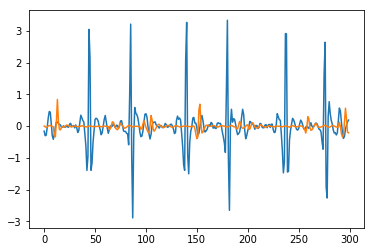

Epoch [32/40], Step [1/10], Loss: 0.7416


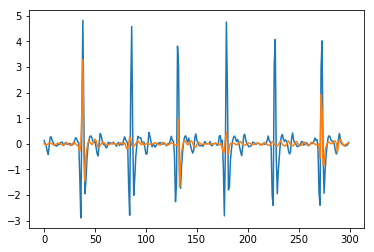

Epoch [32/40], Step [3/10], Loss: 0.7692
Epoch [32/40], Step [5/10], Loss: 0.8100
Epoch [32/40], Step [7/10], Loss: 0.7145
Epoch [32/40], Step [9/10], Loss: 0.7177


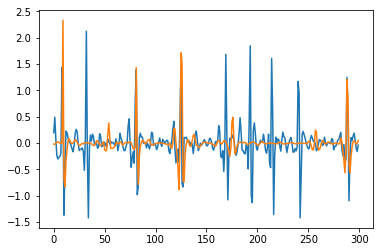

Epoch [33/40], Step [1/10], Loss: 0.8239


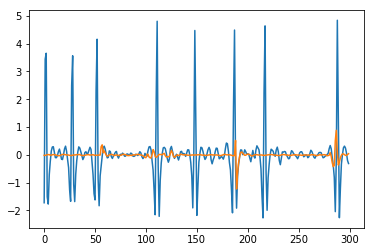

Epoch [33/40], Step [3/10], Loss: 0.8241
Epoch [33/40], Step [5/10], Loss: 0.7576
Epoch [33/40], Step [7/10], Loss: 0.6555
Epoch [33/40], Step [9/10], Loss: 0.6209


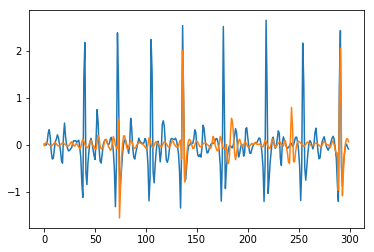

Epoch [34/40], Step [1/10], Loss: 0.8472


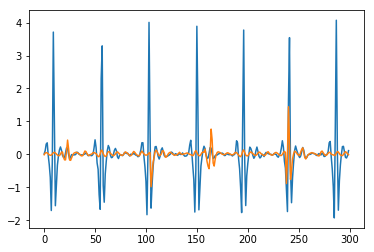

Epoch [34/40], Step [3/10], Loss: 0.7376
Epoch [34/40], Step [5/10], Loss: 0.6849
Epoch [34/40], Step [7/10], Loss: 0.7044
Epoch [34/40], Step [9/10], Loss: 0.7343


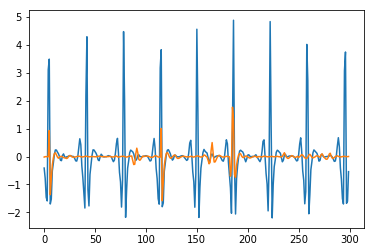

Epoch [35/40], Step [1/10], Loss: 0.6549


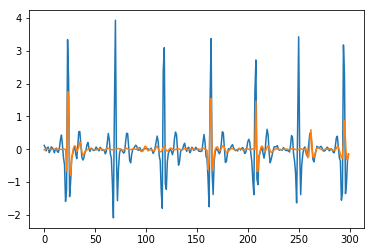

Epoch [35/40], Step [3/10], Loss: 0.7421
Epoch [35/40], Step [5/10], Loss: 0.7387
Epoch [35/40], Step [7/10], Loss: 0.7526
Epoch [35/40], Step [9/10], Loss: 0.7006


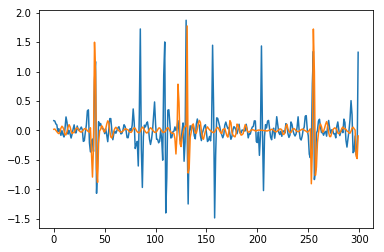

Epoch [36/40], Step [1/10], Loss: 0.7307


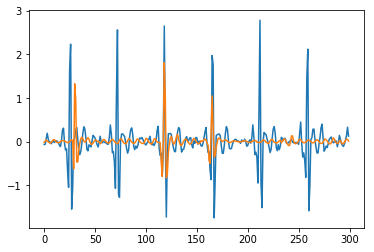

Epoch [36/40], Step [3/10], Loss: 0.8061
Epoch [36/40], Step [5/10], Loss: 0.6837
Epoch [36/40], Step [7/10], Loss: 0.7205
Epoch [36/40], Step [9/10], Loss: 0.7957


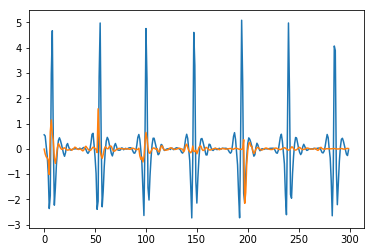

Epoch [37/40], Step [1/10], Loss: 0.6102


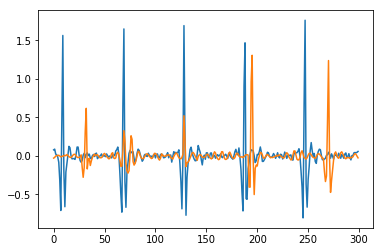

Epoch [37/40], Step [3/10], Loss: 0.6347
Epoch [37/40], Step [5/10], Loss: 0.6635
Epoch [37/40], Step [7/10], Loss: 0.7805
Epoch [37/40], Step [9/10], Loss: 0.7670


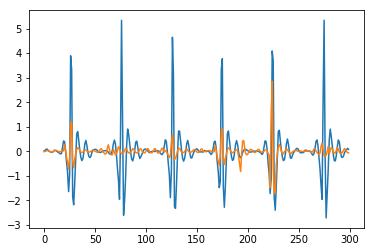

Epoch [38/40], Step [1/10], Loss: 0.7907


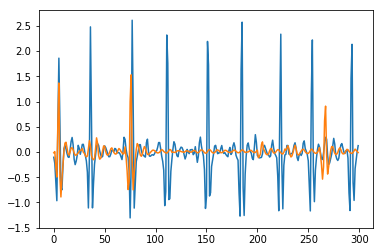

Epoch [38/40], Step [3/10], Loss: 0.7748
Epoch [38/40], Step [5/10], Loss: 0.6756
Epoch [38/40], Step [7/10], Loss: 0.7945
Epoch [38/40], Step [9/10], Loss: 0.7080


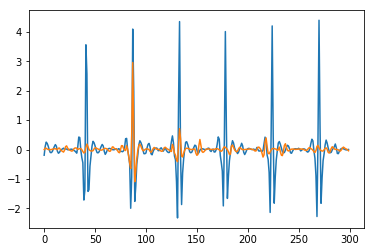

Epoch [39/40], Step [1/10], Loss: 0.5701


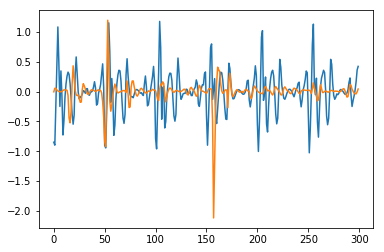

Epoch [39/40], Step [3/10], Loss: 0.7012
Epoch [39/40], Step [5/10], Loss: 0.7712
Epoch [39/40], Step [7/10], Loss: 0.7801
Epoch [39/40], Step [9/10], Loss: 0.7611


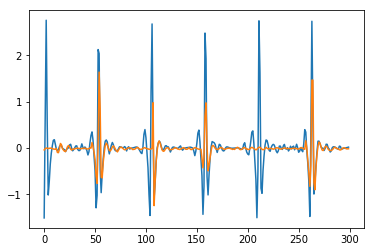

Epoch [40/40], Step [1/10], Loss: 0.6866


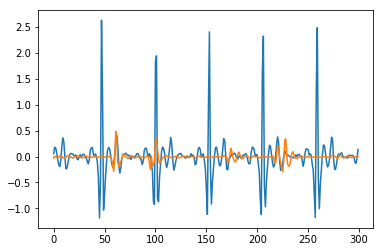

Epoch [40/40], Step [3/10], Loss: 0.7474
Epoch [40/40], Step [5/10], Loss: 0.8124
Epoch [40/40], Step [7/10], Loss: 0.7023
Epoch [40/40], Step [9/10], Loss: 0.6742


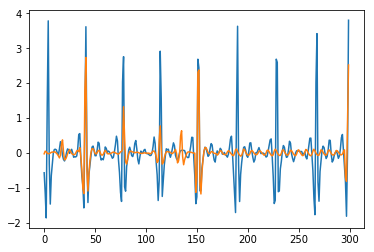

In [134]:
train(model, train_dataset, 40, optimizer, criterion, print_every=2, plot_every = 9, tfr = 0.05)

In [44]:
test_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [48]:
def eval(model, criterion, plot_every):
    model.eval()
    total_step = len(test_loader)
        
    for i, (ecg, labels, label_idx) in enumerate(test_loader):

        src = ecg.to(device).transpose(0, 1).float()
        trg = ecg.to(device).transpose(0, 1).float()

        output = model(src, trg, 0.0)

        loss = criterion(output, trg )

        print ('Step [{}/{}], Loss: {:.4f}' 
               .format(i+1, total_step, loss.item()))

        if (i % plot_every == 0):
            for led in range (12):
                plt.plot(src.detach().transpose(0, 1)[0].transpose(0, 1)[led].cpu().numpy())
                plt.plot(output.detach().transpose(0, 1)[0].transpose(0, 1)[led].cpu().numpy())
                plt.show()